In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from IPython import display
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rc(
    "figure",
    figsize=(12,8),
    autolayout = True
)

plt.rc(
    "axes",
    labelsize = 16,
    labelweight = 'bold',
    titlesize = 18,
    titleweight = 'bold',
    titlepad = 10
)

plot_params = dict(
        color = '0.75',
        markeredgecolor = '0.25',
        markerfacecolor = '0.25',
        style = '.-',
        legend = False
)

In [2]:
data = pd.read_csv("Downloads/daily-minimum-temperatures-in-me.csv")

data.head()

Date Daily minimum temperatures
0  1/1/1981                       20.7
1  1/2/1981                       17.9
2  1/3/1981                       18.8
3  1/4/1981                       14.6
4  1/5/1981                       15.8

In [3]:
data.shape

(3650, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [5]:
df = data.copy()

In [6]:
df.rename(columns = {'Date': 'date', 'Daily minimum temperatures': 'dmin_temp'}, inplace = True)
df.head()

date dmin_temp
0  1/1/1981      20.7
1  1/2/1981      17.9
2  1/3/1981      18.8
3  1/4/1981      14.6
4  1/5/1981      15.8

In [7]:
df['dmin_temp'].unique()

array(['20.7', '17.9', '18.8', '14.6', '15.8', '17.4', '21.8', '20',
       '16.2', '13.3', '16.7', '21.5', '25', '20.6', '24.8', '17.7',
       '15.5', '18.2', '12.1', '14.4', '16', '16.5', '18.7', '19.4',
       '17.2', '15.1', '15.4', '15.3', '21.9', '19.9', '16.6', '16.8',
       '17.1', '15', '13.7', '13.9', '18.3', '22', '22.1', '21.2', '18.4',
       '16.1', '15.7', '18.5', '16.9', '17.5', '17.8', '18.6', '17',
       '14.3', '11.4', '16.3', '11.8', '12.2', '14.7', '11.3', '10.6',
       '11.7', '14.2', '11.2', '8.1', '8', '8.8', '13.4', '10.9', '11',
       '14.5', '18.1', '10', '14.9', '15.9', '13', '7.6', '11.5', '13.5',
       '12.4', '13.2', '13.8', '9', '9.8', '8.9', '7.4', '9.9', '9.3',
       '8.6', '11.9', '14', '12', '10.5', '10.7', '10.1', '5.3', '6.6',
       '8.5', '5.9', '3.2', '2.1', '3.4', '5.4', '9.6', '12.3', '12.6',
       '12.8', '11.6', '5.7', '7.1', '2.5', '3.5', '4.6', '7.7', '10.4',
       '9.2', '6.1', '2.7', '4.3', '6.3', '3.8', '4.4', '4.8', '5.8',
   

In [8]:
df['dmin_temp'].replace({'?0.1':'20.1', '?0.2' : '20.2', '?0.8' : '20.8'}, inplace=True)

In [9]:
df['dmin_temp'] = df['dmin_temp'].astype('float')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       3650 non-null   object 
 1   dmin_temp  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [11]:
px.box(df, x = 'dmin_temp')

In [12]:
q = df['dmin_temp'].quantile(0.99)
df_update = df[df['dmin_temp'] <= q]

In [13]:
px.box(df_update, x='dmin_temp')

In [14]:
df_update.head()

date  dmin_temp
0  1/1/1981       20.7
1  1/2/1981       17.9
2  1/3/1981       18.8
3  1/4/1981       14.6
4  1/5/1981       15.8

In [15]:
df_update['date'] = pd.to_datetime(df_update['date'])
df_update['year'] = df_update['date'].apply(lambda x: x.year)
df_update['month'] = df_update['date'].apply(lambda x: x.month)
df_update['day'] = df_update['date'].apply(lambda x: x.day)


df_update.set_index('date', inplace=True)
df_update = df_update.resample('D').mean()
df_update['day_name'] = df_update.index.strftime('%a')
df_update.head()

dmin_temp    year  month  day day_name
date                                              
1981-01-01       20.7  1981.0    1.0  1.0      Thu
1981-01-02       17.9  1981.0    1.0  2.0      Fri
1981-01-03       18.8  1981.0    1.0  3.0      Sat
1981-01-04       14.6  1981.0    1.0  4.0      Sun
1981-01-05       15.8  1981.0    1.0  5.0      Mon

In [16]:
df_update.groupby('dmin_temp')['day_name'].max()

dmin_temp
0.0     Sun
0.3     Wed
0.5     Wed
0.6     Sun
0.7     Mon
       ... 
20.9    Fri
21.0    Wed
21.1    Sat
21.2    Sat
21.4    Thu
Name: day_name, Length: 206, dtype: object

<AxesSubplot:xlabel='date'>

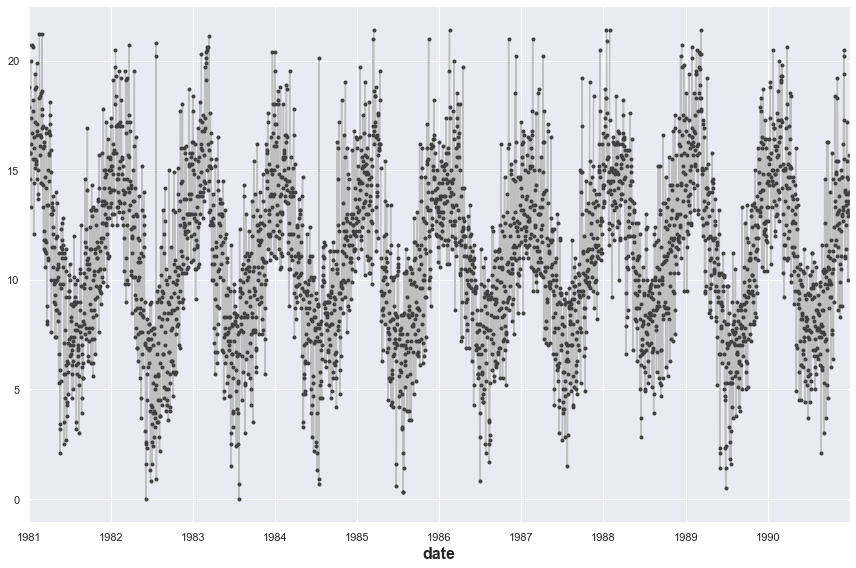

In [17]:
df_update['dmin_temp'].plot(**plot_params)


In [18]:
fig_1 = px.box(df_update, x='day_name', y='dmin_temp')

In [19]:
fig_1.show()

In [20]:
df_update['month_name'] = df_update.index.strftime('%b')

In [21]:
df_update.head()

dmin_temp    year  month  day day_name month_name
date                                                         
1981-01-01       20.7  1981.0    1.0  1.0      Thu        Jan
1981-01-02       17.9  1981.0    1.0  2.0      Fri        Jan
1981-01-03       18.8  1981.0    1.0  3.0      Sat        Jan
1981-01-04       14.6  1981.0    1.0  4.0      Sun        Jan
1981-01-05       15.8  1981.0    1.0  5.0      Mon        Jan

In [22]:
fig_2 = px.box(df_update, x = "month_name", y='dmin_temp')
fig_2.show()

The skewness of the distribution is:  0.042867002080544864


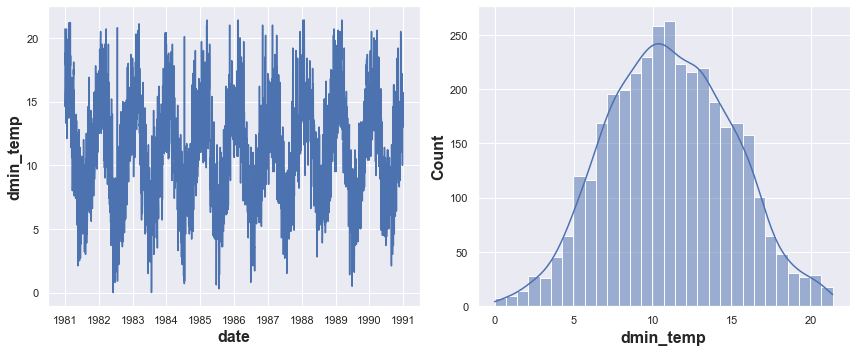

In [23]:
def hist_plot(ts):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
    sns.histplot()
    sns.lineplot(data = ts, ax = ax0)
    sns.histplot(data = ts, kde = True, ax = ax1)
    print('The skewness of the distribution is: ', ts.skew())
hist_plot(df_update['dmin_temp'])

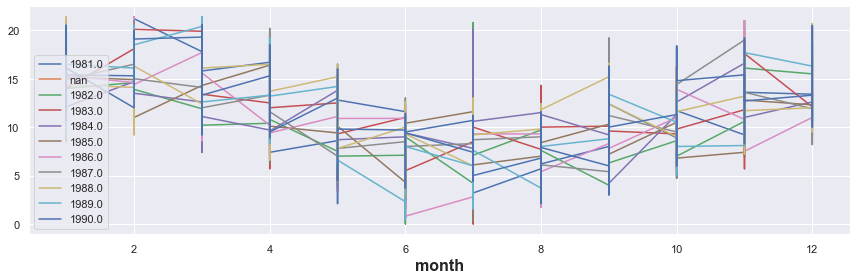

In [24]:
years = df_update['year'].unique()
fig, ax = plt.subplots(figsize=(12,4))
for year in years:
    df_temp = df_update[df_update['year'] == year]
    df_temp.plot('month', 'dmin_temp', ax=ax)
plt.legend(years);

In [25]:
df_update.head()

dmin_temp    year  month  day day_name month_name
date                                                         
1981-01-01       20.7  1981.0    1.0  1.0      Thu        Jan
1981-01-02       17.9  1981.0    1.0  2.0      Fri        Jan
1981-01-03       18.8  1981.0    1.0  3.0      Sat        Jan
1981-01-04       14.6  1981.0    1.0  4.0      Sun        Jan
1981-01-05       15.8  1981.0    1.0  5.0      Mon        Jan

The skewness of the distribution is:  -0.03922195039245939


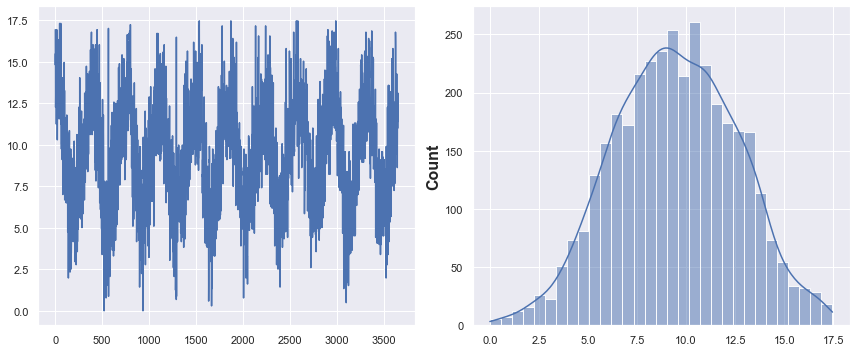

In [26]:
pt = PowerTransformer(method = 'yeo-johnson', standardize=False)
box_cox_close = pd.Series(pt.fit_transform(df_update['dmin_temp'].to_numpy().reshape(-1, 1)).ravel())
hist_plot(box_cox_close)

<AxesSubplot:xlabel='date'>

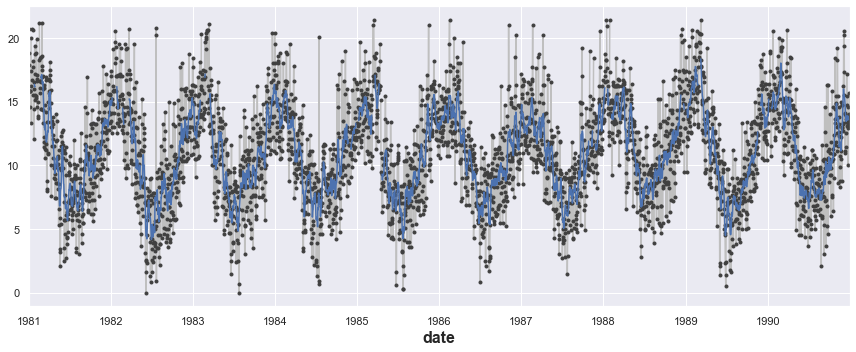

In [27]:
plt.figure(figsize=(12,5))
df_update['dmin_temp'].plot(**plot_params)
df_update['dmin_temp'].rolling(12, center=True).mean().plot()

In [28]:
df_update['6-MA'] = df_update['dmin_temp'].rolling(6, center=True).mean()
df_update['12-MA'] = df_update['dmin_temp'].rolling(12, center=True).mean()
df_update['2-MA'] = df_update['dmin_temp'].rolling(2, center=True).mean()

<AxesSubplot:xlabel='date'>

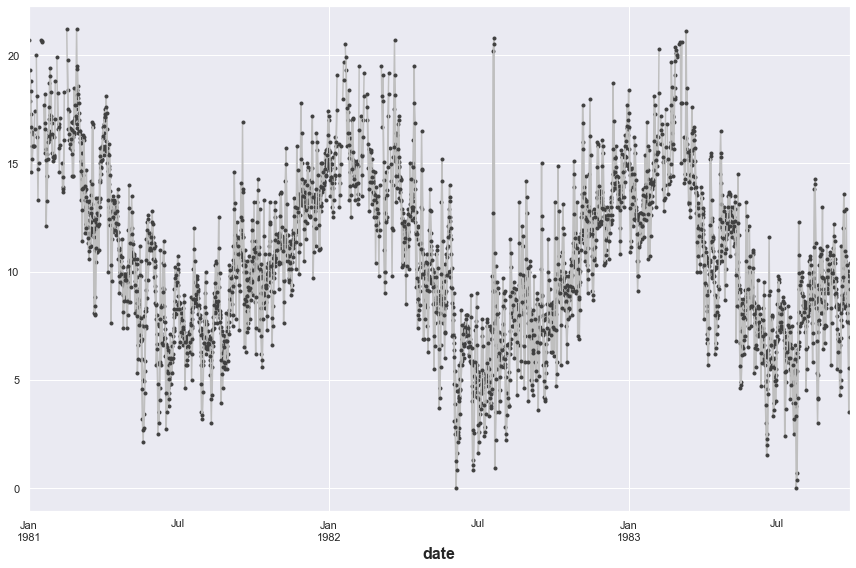

In [29]:
df_update[['dmin_temp', '6-MA', '12-MA', '2-MA']].iloc[:1000].plot(**plot_params)

<AxesSubplot:xlabel='date'>

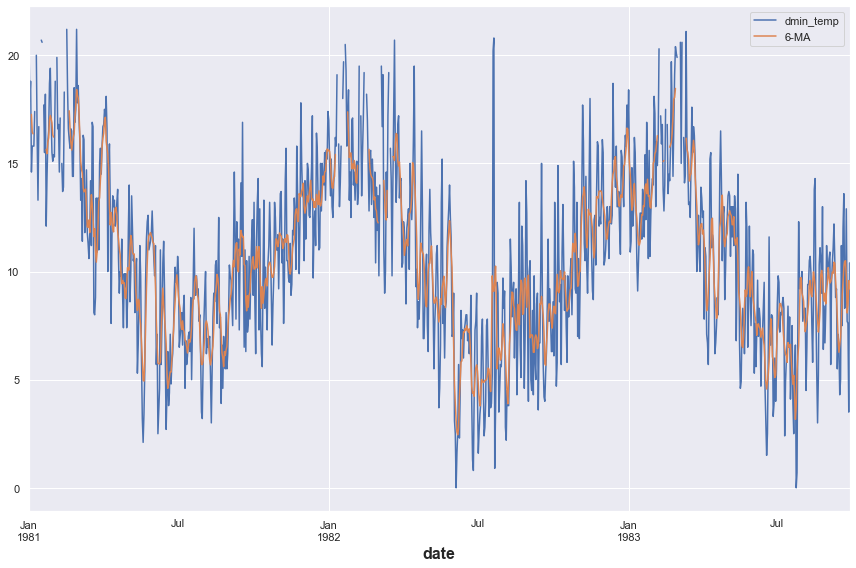

In [30]:
df_update[['dmin_temp', '6-MA']].iloc[:1000].plot()

In [31]:
df_update['EWMA'] = df['dmin_temp'].ewm(alpha = 0.05, adjust=True).mean()

<AxesSubplot:xlabel='date'>

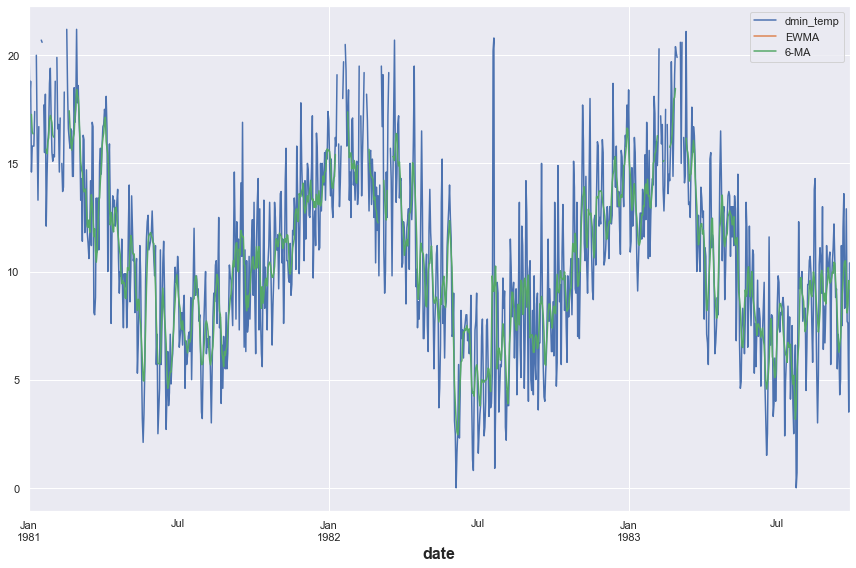

In [32]:
df_update[['dmin_temp', 'EWMA', '6-MA']].iloc[:1000].plot()

In [33]:
df_update.head()

dmin_temp    year  month  day day_name month_name       6-MA  \
date                                                                       
1981-01-01       20.7  1981.0    1.0  1.0      Thu        Jan        NaN   
1981-01-02       17.9  1981.0    1.0  2.0      Fri        Jan        NaN   
1981-01-03       18.8  1981.0    1.0  3.0      Sat        Jan        NaN   
1981-01-04       14.6  1981.0    1.0  4.0      Sun        Jan  17.266667   
1981-01-05       15.8  1981.0    1.0  5.0      Mon        Jan  16.450000   

            12-MA   2-MA  EWMA  
date                            
1981-01-01    NaN    NaN   NaN  
1981-01-02    NaN  19.30   NaN  
1981-01-03    NaN  18.35   NaN  
1981-01-04    NaN  16.70   NaN  
1981-01-05    NaN  15.20   NaN

In [34]:
df = df_update[['dmin_temp', 'year', 'month', 'day']]

In [35]:
df.head()

dmin_temp    year  month  day
date                                     
1981-01-01       20.7  1981.0    1.0  1.0
1981-01-02       17.9  1981.0    1.0  2.0
1981-01-03       18.8  1981.0    1.0  3.0
1981-01-04       14.6  1981.0    1.0  4.0
1981-01-05       15.8  1981.0    1.0  5.0

In [36]:
df.isna().sum()

dmin_temp    35
year         35
month        35
day          35
dtype: int64

In [37]:
df = df.dropna(axis = 0)
df.isna().sum()

dmin_temp    0
year         0
month        0
day          0
dtype: int64

In [38]:
df = df.resample('M').mean()

In [39]:
df.isna().sum()

dmin_temp    0
year         0
month        0
day          0
dtype: int64

<Figure size 864x360 with 0 Axes>

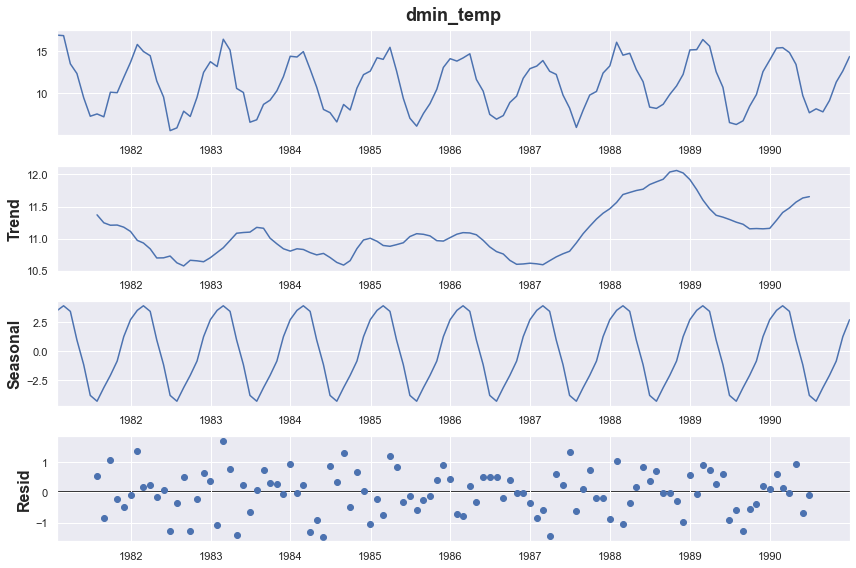

In [40]:
result = seasonal_decompose(df['dmin_temp'])

plt.figure(figsize=(12,5))
result.plot();

### Time series modeling

In [41]:
data = df[['dmin_temp']]
data.head()

dmin_temp
date                 
1981-01-31  16.888889
1981-02-28  16.833333
1981-03-31  13.500000
1981-04-30  12.356667
1981-05-31   9.490323

In [42]:
data.index

DatetimeIndex(['1981-01-31', '1981-02-28', '1981-03-31', '1981-04-30',
               '1981-05-31', '1981-06-30', '1981-07-31', '1981-08-31',
               '1981-09-30', '1981-10-31',
               ...
               '1990-03-31', '1990-04-30', '1990-05-31', '1990-06-30',
               '1990-07-31', '1990-08-31', '1990-09-30', '1990-10-31',
               '1990-11-30', '1990-12-31'],
              dtype='datetime64[ns]', name='date', length=120, freq='M')

In [43]:
dp = DeterministicProcess(index = data.index, constant =True, drop=True, order=1)

X = dp.in_sample()
X

const  trend
date                    
1981-01-31    1.0    1.0
1981-02-28    1.0    2.0
1981-03-31    1.0    3.0
1981-04-30    1.0    4.0
1981-05-31    1.0    5.0
...           ...    ...
1990-08-31    1.0  116.0
1990-09-30    1.0  117.0
1990-10-31    1.0  118.0
1990-11-30    1.0  119.0
1990-12-31    1.0  120.0

[120 rows x 2 columns]

In [44]:
y = data['dmin_temp']

In [45]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [46]:
y_pred = pd.Series(model.predict(X), index = X.index)

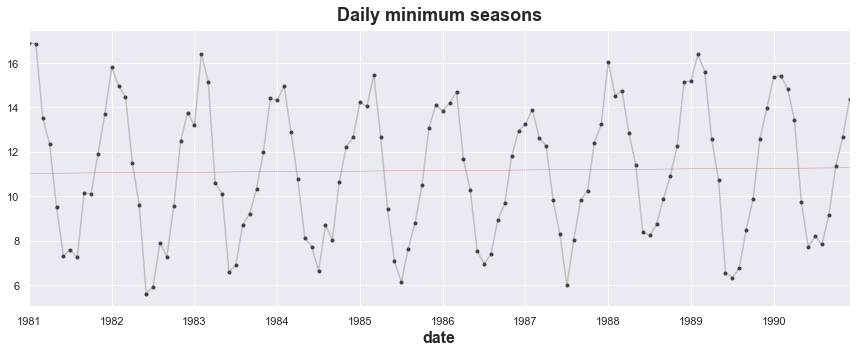

In [47]:
fig, ax = plt.subplots(figsize=(12,5))
ax = y.plot(**plot_params, title = "Daily minimum seasons")
y_pred.plot(ax = ax, linewidth=0.3, color = 'C3')
plt.show()

In [48]:
X_fore = dp.out_of_sample(steps = 7)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

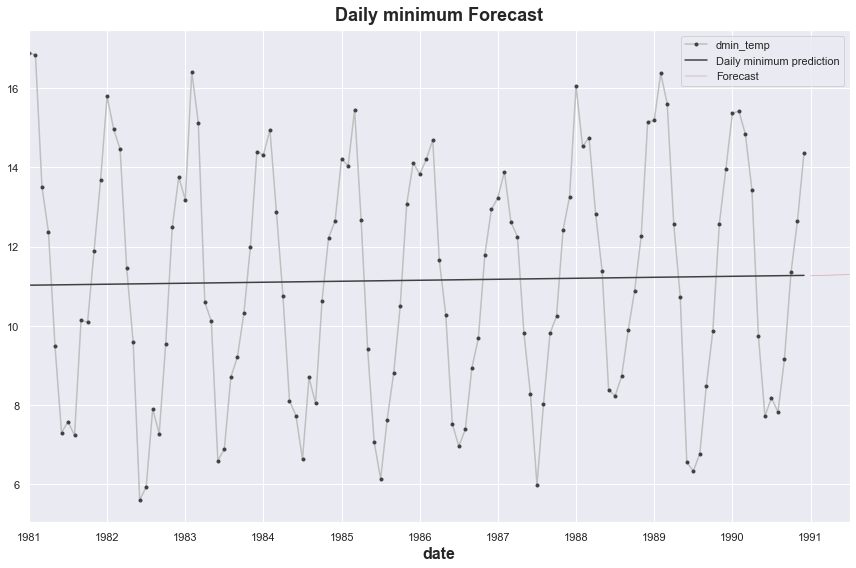

In [49]:
fig, ax = plt.subplots()
ax = y.plot(**plot_params, title="Daily minimum Forecast")
ax = y_pred.plot(color = '0.25', label = "Daily minimum prediction")
y_fore.plot(ax = ax, linewidth = 0.3, color = 'C3', label = "Forecast")
plt.legend()
plt.show()

In [50]:
from xgboost import XGBRegressor

In [51]:
data

dmin_temp
date                 
1981-01-31  16.888889
1981-02-28  16.833333
1981-03-31  13.500000
1981-04-30  12.356667
1981-05-31   9.490323
...               ...
1990-08-31   7.825806
1990-09-30   9.166667
1990-10-31  11.345161
1990-11-30  12.656667
1990-12-31  14.367742

[120 rows x 1 columns]

In [52]:
train_data = data[data.index <= "1989-01-01"]
test_data = data[data.index > "1989-01-31"]

In [53]:
train_data.shape, test_data.shape

((96, 1), (23, 1))

In [54]:
data.shape

(120, 1)

In [55]:
train_data.index.min(), train_data.index.max() 

(Timestamp('1981-01-31 00:00:00', freq='M'),
 Timestamp('1988-12-31 00:00:00', freq='M'))

In [56]:
test_data.index.min(), test_data.index.max()

(Timestamp('1989-02-28 00:00:00', freq='M'),
 Timestamp('1990-12-31 00:00:00', freq='M'))

In [57]:
train_data['Target'] = train_data['dmin_temp'].shift(-1)

train_data

dmin_temp     Target
date                            
1981-01-31  16.888889  16.833333
1981-02-28  16.833333  13.500000
1981-03-31  13.500000  12.356667
1981-04-30  12.356667   9.490323
1981-05-31   9.490323   7.306667
...               ...        ...
1988-08-31   8.725806   9.883333
1988-09-30   9.883333  10.890323
1988-10-31  10.890323  12.253333
1988-11-30  12.253333  15.144828
1988-12-31  15.144828        NaN

[96 rows x 2 columns]

In [58]:
train_data = train_data.dropna()

In [59]:
test_data['Target'] = test_data['dmin_temp'].shift(-1)

test_data

dmin_temp     Target
date                            
1989-02-28  16.371429  15.596667
1989-03-31  15.596667  12.563333
1989-04-30  12.563333  10.725806
1989-05-31  10.725806   6.560000
1989-06-30   6.560000   6.332258
1989-07-31   6.332258   6.770968
1989-08-31   6.770968   8.486667
1989-09-30   8.486667   9.867742
1989-10-31   9.867742  12.575862
1989-11-30  12.575862  13.951613
1989-12-31  13.951613  15.360000
1990-01-31  15.360000  15.417857
1990-02-28  15.417857  14.835484
1990-03-31  14.835484  13.433333
1990-04-30  13.433333   9.748387
1990-05-31   9.748387   7.720000
1990-06-30   7.720000   8.183871
1990-07-31   8.183871   7.825806
1990-08-31   7.825806   9.166667
1990-09-30   9.166667  11.345161
1990-10-31  11.345161  12.656667
1990-11-30  12.656667  14.367742
1990-12-31  14.367742        NaN

In [60]:
test_data = test_data.dropna()

test_data

dmin_temp     Target
date                            
1989-02-28  16.371429  15.596667
1989-03-31  15.596667  12.563333
1989-04-30  12.563333  10.725806
1989-05-31  10.725806   6.560000
1989-06-30   6.560000   6.332258
1989-07-31   6.332258   6.770968
1989-08-31   6.770968   8.486667
1989-09-30   8.486667   9.867742
1989-10-31   9.867742  12.575862
1989-11-30  12.575862  13.951613
1989-12-31  13.951613  15.360000
1990-01-31  15.360000  15.417857
1990-02-28  15.417857  14.835484
1990-03-31  14.835484  13.433333
1990-04-30  13.433333   9.748387
1990-05-31   9.748387   7.720000
1990-06-30   7.720000   8.183871
1990-07-31   8.183871   7.825806
1990-08-31   7.825806   9.166667
1990-09-30   9.166667  11.345161
1990-10-31  11.345161  12.656667
1990-11-30  12.656667  14.367742

In [61]:
train_data.head()

dmin_temp     Target
date                            
1981-01-31  16.888889  16.833333
1981-02-28  16.833333  13.500000
1981-03-31  13.500000  12.356667
1981-04-30  12.356667   9.490323
1981-05-31   9.490323   7.306667

In [62]:
X_train = train_data.loc[:, ['dmin_temp']]
X_test = test_data.loc[:, ['dmin_temp']]
y_train = train_data.loc[:, 'Target']
y_test = test_data.loc[:, 'Target']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95, 1), (22, 1), (95,), (22,))

In [63]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [64]:
model.score(X_test, y_test)

0.6808552419416891

In [65]:
y_pred_xgb = pd.Series(model.predict(X_test)[0], index = X_test.index)

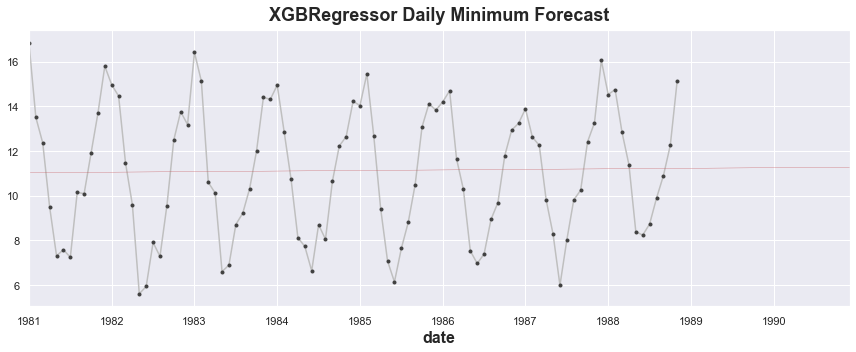

In [66]:
fig, ax = plt.subplots(figsize=(12,5))
ax = y_train.plot(**plot_params, title='XGBRegressor Daily Minimum Forecast')
y_pred.plot(ax = ax, linewidth = 0.3, color = "C3", label = 'Prediction')
plt.show()

In [67]:
y_pred_xgb[0]

15.073677

In [68]:
test_data.iloc[0]

dmin_temp    16.371429
Target       15.596667
Name: 1989-02-28 00:00:00, dtype: float64

In [ ]:
ExponentialSmoothing()